## Costa Rica Carbon Pre-Proposal: Aggregated Watershed properties
[Emilio Mayorga](https://github.com/emiliom/)

- 4/2/2019. Run successfully with Python 3.7 (except for plot styles?!)
- 1/19/2017

- Elevation (mean, median & max?)
- Population (total)
- Precipitation (annual precip; and some measure of seasonality?)
- %Forest (GFC, updated to 2012?)

In [45]:
%matplotlib inline

import os

import matplotlib.pyplot as plt

# The two statemens below are used mainly to set up a plotting
# default style that's better than the default from matplotlib
#import seaborn as sns
#plt.style.use('bmh')

import numpy as np
import pandas as pd
import geopandas as gpd

import rasterio

import rasterstats as rs

### Load and prepare watersheds

In [46]:
data_pth = "/home/mayorga/Desktop/CRRiverNetCarbon/geodata"

In [47]:
watersheds = gpd.read_file(os.path.join(
                           data_pth, "sarapiqui_tempisque_hybas_na_lev00_v1c.shp"))

**TWEAK TO SHOW SUBWATERSHED BOUNDARIES!**

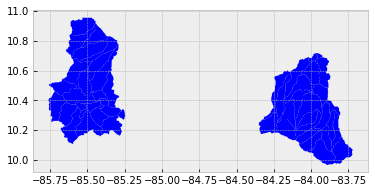

In [48]:
watersheds.plot();

In [5]:
watersheds['PFAF_7'].unique()

array([7711160, 7538020])

In [6]:
watersheds_2 = watersheds[['HYBAS_ID', 'NEXT_DOWN', 'SUB_AREA', 'UP_AREA',
                           'PFAF_12', 'PFAF_7', 'geometry']]

### General scheme for zonal_stats
- First create gdf of the two aggregate watersheds by using geopandas dissolve on PFAF_7! This will simplify everything
- geojson_out isn't needed, but I'll keep it b/c it's the easiest way to preserve the gdf attributes and convert to pandas (geo)DF
- at the end, merge the individual DF tables

### Easiest if I just dissolve the watersheds on PFAF_7, then do zonal_stats on that!

In [7]:
cols = ['PFAF_7', 'SUB_AREA', 'geometry']
watersheds_agg = watersheds_2[cols].dissolve(by='PFAF_7', aggfunc='sum', as_index=False)
watersheds_agg.crs = watersheds_2.crs
watersheds_agg

,PFAF_7,geometry,SUB_AREA
0,7538020,POLYGON ((-83.79583333333331 10.15416666666668...,3093.5
1,7711160,POLYGON ((-85.29166666666664 10.29166666666668...,3269.5


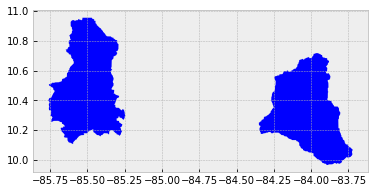

In [8]:
watersheds_agg.plot();

### 1. Elevation

In [9]:
elev_pth = os.path.join(data_pth, 'HydroSHEDS/geo/ca/20140302/ca_dem_15s/hdr.adf')

In [10]:
elev_gjson = rs.zonal_stats(watersheds_agg, elev_pth, prefix='elev_m_', 
                            all_touched=False, stats=['mean', 'median', 'max'],
                            geojson_out=True) # nodata=-9999, 

In [11]:
elev_gdf = gpd.GeoDataFrame.from_features(elev_gjson)
elev_gdf.drop(['geometry'], axis=1, inplace=True)
elev_gdf.head()

,PFAF_7,SUB_AREA,elev_m_max,elev_m_mean,elev_m_median
0,7538020,3093.5,3379.0,669.813626,287.0
1,7711160,3269.5,1859.0,172.934741,99.0


### 2. Population
Total and population density? Since the two watersheds are about the same size ...

In [12]:
pop_pth = os.path.join(data_pth, 'Americas-POP-1KM/LAC_PPP_2015_adj_v2.tif')

In [13]:
# Use sum stats assumes 0.00833333 deg = 1 km
pop_gjson = rs.zonal_stats(watersheds_agg, pop_pth, prefix='popdens_', 
                           all_touched=False, stats=['mean', 'sum'],
                           geojson_out=True) # nodata=-9999, 

In [14]:
pop_gdf = gpd.GeoDataFrame.from_features(pop_gjson)
pop_gdf.drop(['geometry'], axis=1, inplace=True)
pop_gdf.head()

,PFAF_7,SUB_AREA,popdens_mean,popdens_sum
0,7538020,3093.5,27.198064,99680.90625
1,7711160,3269.5,40.845187,158152.56250


### 3. Precipitation
- annual precip; and some measure of seasonality?
- resample grid first, to get better accuracy

In [15]:
from functools import reduce
from affine import Affine
import scipy.ndimage

In [16]:
def grid_resample(fpth, scale=2.0):
    with rasterio.open(fpth) as src:
        transform = src.transform  # returns an affine.Affine object
        grd2darray = src.read(1)

    # order=0: nearest-neighbor resampling
    grd2darray_rs = scipy.ndimage.zoom(grd2darray, scale, order=0)
    transform_rs = transform*Affine.scale(1/float(scale))
    return grd2darray_rs, transform_rs

In [17]:
ppt_pth = os.path.join(data_pth, 'CHPclim_v1.0/90N-90S.landonly/monthly')

In [18]:
months = range(1,13)

ppt_df_dct = {}
for m in months:
    mstr = '{0:02}'.format(m)
    ppt_m_pth = os.path.join(ppt_pth, 'CHPclim.{0}.tif'.format(mstr))
    grd2darray_rs, transform_rs = grid_resample(ppt_m_pth, scale=5.0)

    ppt_m_gjson = rs.zonal_stats(watersheds_agg, grd2darray_rs, affine=transform_rs,
                                 nodata=-9999, all_touched=False, stats='mean',
                                 prefix='ppt_{0}_'.format(mstr), geojson_out=True)
    ppt_m_gdf = gpd.GeoDataFrame.from_features(ppt_m_gjson)
    ppt_m_gdf.drop(['geometry', 'SUB_AREA'], axis=1, inplace=True)
    ppt_df_dct[mstr] = ppt_m_gdf.copy()

In [19]:
# clean up from memory
del grd2darray_rs

In [20]:
len(ppt_df_dct), sorted(ppt_df_dct.keys())

(12, ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [23]:
dfs = [ppt_df_dct[mstr] for mstr in sorted(ppt_df_dct.keys())]
ppt_all_df = reduce(lambda left,right: pd.merge(left, right, on='PFAF_7'), dfs)
ppt_all_df

,PFAF_7,ppt_01_mean,ppt_02_mean,ppt_03_mean,ppt_04_mean,ppt_05_mean,ppt_06_mean,ppt_07_mean,ppt_08_mean,ppt_09_mean,ppt_10_mean,ppt_11_mean,ppt_12_mean
0,7538020,286.483426,117.017048,107.051669,146.461706,312.939957,377.286968,419.852354,365.206002,341.669915,388.477496,431.864488,400.852671
1,7711160,6.415481,2.518622,5.372347,25.994841,243.600333,246.681487,166.936898,197.856606,305.348834,290.571407,133.862632,24.904903


In [24]:
ppt_m_cols = ['ppt_{0}_mean'.format(mstr) for mstr in sorted(ppt_df_dct.keys())]

In [25]:
ppt_all_df['ppt_annual'] = ppt_all_df[ppt_m_cols].sum(axis=1)

In [26]:
ppt_all_df

,PFAF_7,ppt_01_mean,ppt_02_mean,ppt_03_mean,ppt_04_mean,ppt_05_mean,ppt_06_mean,ppt_07_mean,ppt_08_mean,ppt_09_mean,ppt_10_mean,ppt_11_mean,ppt_12_mean,ppt_annual
0,7538020,286.483426,117.017048,107.051669,146.461706,312.939957,377.286968,419.852354,365.206002,341.669915,388.477496,431.864488,400.852671,3695.163701
1,7711160,6.415481,2.518622,5.372347,25.994841,243.600333,246.681487,166.936898,197.856606,305.348834,290.571407,133.862632,24.904903,1650.064391


In [27]:
ppt_all_df[['PFAF_7', 'ppt_annual']]

,PFAF_7,ppt_annual
0,7538020,3695.163701
1,7711160,1650.064391


### 4. GFC %Forest (LULC)
 - Need to download the loss and gain grids, then process all 3 grids.** Processing can be done directly here, after reading via rasterio.**
 - But note all the `MemoryErrors` I ran into!
 - Used "version 1.0", https://earthenginepartners.appspot.com/science-2013-global-forest/download_v1.0.html

In [28]:
# print np.sctypeDict.keys()

In [29]:
forloss2012_pth = os.path.join(data_pth, 'GFC/Hansen_GFC2013_loss_20N_090W.tif')
with rasterio.open(forloss2012_pth) as src:
    grd2darray_forloss2012 = src.read(1).astype('int8')

forgain2012_pth = os.path.join(data_pth, 'GFC/Hansen_GFC2013_gain_20N_090W.tif')
with rasterio.open(forgain2012_pth) as src:
    grd2darray_forgain2012 = src.read(1).astype('int8')

In [30]:
fornetloss2012presence = grd2darray_forgain2012 - grd2darray_forloss2012

In [31]:
del grd2darray_forgain2012, grd2darray_forloss2012

In [32]:
fornetloss2012presence.dtype, fornetloss2012presence.max(), fornetloss2012presence.min()

(dtype('int8'), 1, -1)

In [33]:
for2000perc_pth = os.path.join(data_pth, 'GFC/Hansen_GFC2013_treecover2000_20N_090W.tif')
with rasterio.open(for2000perc_pth) as src:
    transform = src.transform  # returns an affine.Affine object
    grd2darray_for2000perc = src.read(1).astype('int8')

# np.where gives MemoryError on my laptop!
# for2000presence = np.where(grd2darray_for2000perc > 50, 1, 0)

grd2darray_for2000perc[(grd2darray_for2000perc <= 50)] = 0
grd2darray_for2000perc[(grd2darray_for2000perc > 50)] = 1

for2000presence = grd2darray_for2000perc

In [34]:
for2000presence.shape, for2000presence.dtype, for2000presence.min(), for2000presence.max()

((36001, 36001), dtype('int8'), 0, 1)

Now calculate 2012 forest presence (1/0)

In [35]:
for2012presence = for2000presence + fornetloss2012presence

In [36]:
for2012presence.max(), for2012presence.min(), for2012presence.mean()

(2, -1, 0.19706593059871216)

In [37]:
# clean up messy edge cases (2 and -1)
for2012presence[for2012presence > 1] = 1
for2012presence[for2012presence < 0] = 0
for2012presence.max(), for2012presence.min(), for2012presence.mean()

(1, 0, 0.19731262214034975)

In [38]:
for2012_gjson = rs.zonal_stats(watersheds_agg, for2012presence, affine=transform, 
                               all_touched=False, stats='sum',
                               prefix='for2012_', geojson_out=True) # nodata=-9999, 

/home/mayorga/miniconda/envs/rivwtshd/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")
/home/mayorga/miniconda/envs/rivwtshd/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [39]:
for2012_gdf = gpd.GeoDataFrame.from_features(for2012_gjson)
for2012_gdf.drop(['geometry'], axis=1, inplace=True)

In [40]:
for2012_gdf['forest_area_km2'] = for2012_gdf['for2012_sum']*(30.0**2/1000.0**2)
for2012_gdf['forest_area_perc'] = 100.0*for2012_gdf['forest_area_km2']/for2012_gdf['SUB_AREA']

In [41]:
for2012_gdf

,PFAF_7,SUB_AREA,for2012_sum,forest_area_km2,forest_area_perc
0,7538020,3093.5,2612631.0,2351.3679,76.009953
1,7711160,3269.5,1464737.0,1318.2633,40.320028


### Merge all the resulting data frames

In [42]:
watershed_props = elev_gdf.merge(pop_gdf.drop('SUB_AREA', axis=1), on='PFAF_7'
                        ).merge(for2012_gdf.drop(['SUB_AREA', 'for2012_sum', 'forest_area_km2'], axis=1),
                                on='PFAF_7'
                        ).merge(ppt_all_df, on='PFAF_7')
watershed_props.rename(columns={'SUB_AREA':'area_total_km2'}, inplace=True)

In [43]:
watershed_props

,PFAF_7,area_total_km2,elev_m_max,elev_m_mean,elev_m_median,popdens_mean,popdens_sum,forest_area_perc,ppt_01_mean,ppt_02_mean,...,ppt_04_mean,ppt_05_mean,ppt_06_mean,ppt_07_mean,ppt_08_mean,ppt_09_mean,ppt_10_mean,ppt_11_mean,ppt_12_mean,ppt_annual
0,7538020,3093.5,3379.0,669.813626,287.0,27.198064,99680.90625,76.009953,286.483426,117.017048,...,146.461706,312.939957,377.286968,419.852354,365.206002,341.669915,388.477496,431.864488,400.852671,3695.163701
1,7711160,3269.5,1859.0,172.934741,99.0,40.845187,158152.56250,40.320028,6.415481,2.518622,...,25.994841,243.600333,246.681487,166.936898,197.856606,305.348834,290.571407,133.862632,24.904903,1650.064391


In [44]:
# watershed_props.to_clipboard()